# ARP - NLP: Topic Modelling

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary NLTK data files for tokenisation and stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/Jey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Jey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 600e - Google News Articles (Split into paragraphs)

In [2]:
articles_original = pd.read_csv('600e - Google News_Articles.csv')
articles = articles_original.copy()
articles.head()

,URL,Published,Text
0,https://news.google.com/articles/CBMikwFodHRwc...,2024-03-12T07:00:00Z,Fiat is hoping to inject some 'La Dolce Vita' ...
1,https://news.google.com/articles/CBMikwFodHRwc...,2024-03-12T07:00:00Z,We've driven the 600e EV to find out if it's w...
2,https://news.google.com/articles/CBMikwFodHRwc...,2024-03-12T07:00:00Z,Fiat's new electric family car: The 600e has a...
3,https://news.google.com/articles/CBMikwFodHRwc...,2024-03-12T07:00:00Z,The original Fiat 600 was launched in 1955 and...
4,https://news.google.com/articles/CBMikwFodHRwc...,2024-03-12T07:00:00Z,"But my word, how it has grown since."


Processed Documents: [['hoping', 'inject', 'dolce', 'vita', 'sweet', 'life', 'motoring', 'lives', 'family', 'crossover'], ['driven', 'ev', 'find', 'worth', 'outlay', 'hold', 'tight', 'hybrid', 'hit', 'showrooms'], ['electric', 'family', 'arrived', 'uk', 'enough', 'range', 'take', 'owners', 'london', 'middlesbrough', 'hit', 'ev', 'pricey', 'britons'], ['original', 'launched', 'sold', 'million', 'across', 'europe', 'discontinued'], ['word', 'grown', 'since']]
Dictionary: {'crossover': 0, 'dolce': 1, 'family': 2, 'hoping': 3, 'inject': 4, 'life': 5, 'lives': 6, 'motoring': 7, 'sweet': 8, 'vita': 9, 'driven': 10, 'ev': 11, 'find': 12, 'hit': 13, 'hold': 14, 'hybrid': 15, 'outlay': 16, 'showrooms': 17, 'tight': 18, 'worth': 19, 'arrived': 20, 'britons': 21, 'electric': 22, 'enough': 23, 'london': 24, 'middlesbrough': 25, 'owners': 26, 'pricey': 27, 'range': 28, 'take': 29, 'uk': 30, 'across': 31, 'discontinued': 32, 'europe': 33, 'launched': 34, 'million': 35, 'original': 36, 'sold': 37, 'g

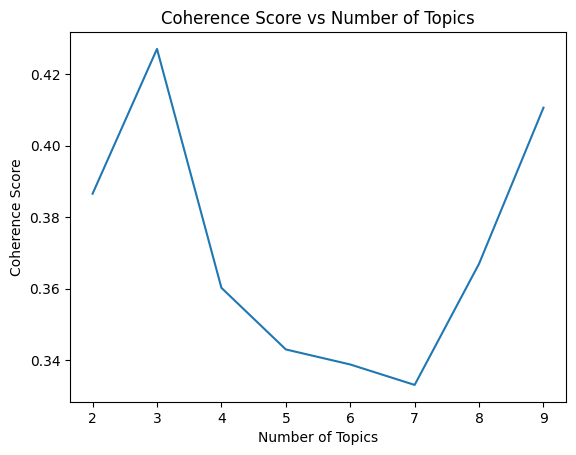

Optimal number of topics: 3


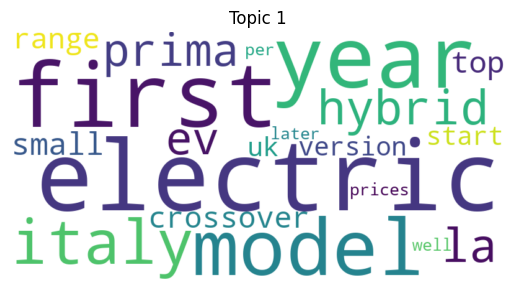

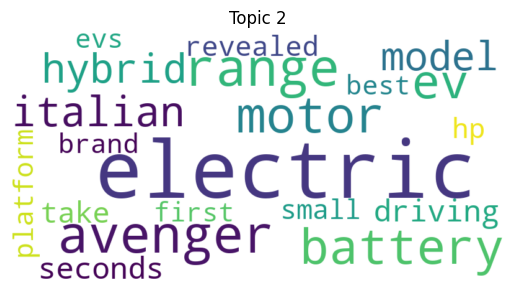

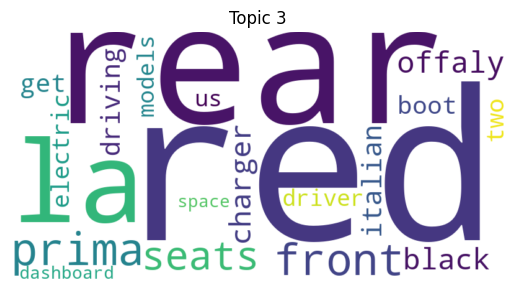

In [3]:
RANDOM_SEED = 3487

# Drop 'URL' and 'Published' columns
articles = articles.drop(columns=['URL', 'Published'])

# Preprocessing Function
def preprocess(text):
    articles_custom_stopwords = set(stopwords.words('english'))
    articles_custom_stopwords.update(['car', 'cars', 'fiat', 'jeep', 'hyundai', 'kona', 'stellantis', 'market',
                         'available', 'would', 'also', 'new', 'level', 'like', 'even', 'according',
                         'offered', 'move', 'one', 'content', 'information', 'interests', 'activity',
                         'presented', 'example'])  # Add stopwords here
    
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in articles_custom_stopwords]
        return tokens
    else:
        return []

articles_custom_stopwords = set(stopwords.words('english'))
articles_custom_stopwords.update(['car', 'cars', 'fiat', 'jeep', 'hyundai', 'kona', 'stellantis', 'market',
                         'available', 'would', 'also', 'new', 'level', 'like', 'even', 'according',
                         'offered', 'move', 'one', 'content', 'information', 'interests', 'activity',
                         'presented', 'example'])  # Add stopwords here
    
# Preprocess the documents
articles_processed_docs = [preprocess(doc) for doc in articles['Text']]
print("Processed Documents:", articles_processed_docs[:5])  # Print only the first 5 for brevity

# Create a dictionary from the processed documents
articles_dictionary = corpora.Dictionary(articles_processed_docs)
print("Dictionary:", articles_dictionary.token2id)

# Create a corpus from the dictionary
articles_corpus = [articles_dictionary.doc2bow(doc) for doc in articles_processed_docs]
print("Corpus:", articles_corpus[:5])  # Print only the first 5 for brevity

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=15,
            random_state=RANDOM_SEED  # Set the random seed here
        )
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
articles_limit = 10
articles_start = 2
articles_step = 1
articles_model_list, articles_coherence_values = compute_coherence_values(articles_dictionary, articles_corpus, articles_processed_docs, articles_limit, articles_start, articles_step)

# Plotting the coherence scores
x = range(articles_start, articles_limit, articles_step)
plt.plot(x, articles_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Choosing the optimal number of topics
articles_optimal_num_topics = x[articles_coherence_values.index(max(articles_coherence_values))]
print(f"Optimal number of topics: {articles_optimal_num_topics}")

# Train the optimal LDA model
articles_optimal_model = articles_model_list[articles_coherence_values.index(max(articles_coherence_values))]

# Visualize topics using word clouds
for i in range(articles_optimal_num_topics):
    plt.figure()
    articles_word_frequencies = dict(articles_optimal_model.show_topic(i, 20))
    articles_filtered_word_frequencies = {word: freq for word, freq in articles_word_frequencies.items() if word not in articles_custom_stopwords}
    articles_wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=50, 
        background_color='white', 
        stopwords=articles_custom_stopwords,
        random_state=RANDOM_SEED  # Set the random seed here
    ).generate_from_frequencies(articles_filtered_word_frequencies)
    plt.imshow(articles_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i+1}")
    plt.show()

In [4]:
# Visualise topics using pyLDAvis
articles_vis = gensimvis.prepare(articles_optimal_model, articles_corpus, articles_dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(articles_vis)

In [5]:
# Get the topic distribution for each document
articles_topic_matrix = [articles_optimal_model[doc] for doc in articles_corpus]

# Extract topic probabilities and add them as columns
articles['Topic 1'] = [dict(doc).get(0, 0) for doc in articles_topic_matrix]
articles['Topic 2'] = [dict(doc).get(1, 0) for doc in articles_topic_matrix]
articles['Topic 3'] = [dict(doc).get(2, 0) for doc in articles_topic_matrix]

# Add 'Date' columns from the original table
articles['Date'] = articles_original['Published']

# Display the table with the new topic columns
articles.head()

,Text,Topic 1,Topic 2,Topic 3,Date
0,Fiat is hoping to inject some 'La Dolce Vita' ...,0.034319,0.036156,0.929525,2024-03-12T07:00:00Z
1,We've driven the 600e EV to find out if it's w...,0.031560,0.936693,0.031748,2024-03-12T07:00:00Z
2,Fiat's new electric family car: The 600e has a...,0.026148,0.412237,0.561614,2024-03-12T07:00:00Z
3,The original Fiat 600 was launched in 1955 and...,0.045167,0.908768,0.046065,2024-03-12T07:00:00Z
4,"But my word, how it has grown since.",0.127067,0.120291,0.752642,2024-03-12T07:00:00Z


In [6]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each article
articles['sentiment'] = articles['Text'].apply(lambda x: analyzer.polarity_scores(x))

# Extract sentiment scores into separate columns
articles['neg'] = articles['sentiment'].apply(lambda x: x['neg'])
articles['neu'] = articles['sentiment'].apply(lambda x: x['neu'])
articles['pos'] = articles['sentiment'].apply(lambda x: x['pos'])
articles['compound'] = articles['sentiment'].apply(lambda x: x['compound'])

# Drop intermediate sentiment column
articles = articles.drop(columns=['sentiment'])

# Display the final DataFrame
print(articles.head())


                                                Text   Topic 1   Topic 2  \
0  Fiat is hoping to inject some 'La Dolce Vita' ...  0.034319  0.036156   
1  We've driven the 600e EV to find out if it's w...  0.031560  0.936693   
2  Fiat's new electric family car: The 600e has a...  0.026148  0.412237   
3  The original Fiat 600 was launched in 1955 and...  0.045167  0.908768   
4              But my word, how it has grown since.   0.127067  0.120291   

    Topic 3                  Date  neg    neu    pos  compound  
0  0.929525  2024-03-12T07:00:00Z  0.0  0.784  0.216    0.7003  
1  0.031748  2024-03-12T07:00:00Z  0.0  0.929  0.071    0.2263  
2  0.561614  2024-03-12T07:00:00Z  0.0  1.000  0.000    0.0000  
3  0.046065  2024-03-12T07:00:00Z  0.0  0.817  0.183    0.4215  
4  0.752642  2024-03-12T07:00:00Z  0.0  1.000  0.000    0.0000  


# 600e - YouTube Transcripts

In [7]:
transcripts_600e_original = pd.read_csv('600e - YouTube Transcripts_Split.csv')
transcripts_600e = transcripts_600e_original.copy()
transcripts_600e.head()

,Video ID,Title,Channel Name,Transcript Part
0,AXGNb76QgH0,NEW Fiat 600E Review: Fantastic or Flawed? | 4K,AutoTrader,foreign 500e and you should it's brilliant but...
1,AXGNb76QgH0,NEW Fiat 600E Review: Fantastic or Flawed? | 4K,AutoTrader,but maybe someone forgot to tell them that the...
2,AXGNb76QgH0,NEW Fiat 600E Review: Fantastic or Flawed? | 4K,AutoTrader,yes the first thing he notices how quiet it is...
3,AXGNb76QgH0,NEW Fiat 600E Review: Fantastic or Flawed? | 4K,AutoTrader,but in here they really do whichever mode you'...
4,AXGNb76QgH0,NEW Fiat 600E Review: Fantastic or Flawed? | 4K,AutoTrader,it's a shame it's not a bit quicker although s...


Processed Documents: [['foreign', 'brilliant', 'small', 'side', 'might', 'thing', 'need', 'new', 'basically', 'bigger', 'chunkier', 'looks', 'suv', 'simple', 'way', 'looking', 'enough', 'people', 'interested', 'suvs', 'super', 'trendy', 'days', 'course', 'skin', 'firstly', 'chunky', 'technically', 'basically', 'built', 'factory', 'poland', 'uses', 'parts', 'found', 'vauxhall', 'market', 'peugeot', 'among', 'french', 'american', 'polish', 'italians', 'sprinkled', 'top', 'matter', 'looks', 'things', 'make', 'look', 'cool', 'cute', 'look', 'meaner', 'large', 'model', 'name', 'center', 'true', 'style', 'rather', 'manufacturer', 'badge', 'sure', 'eyelids', 'jerry', 'feet', 'done', 'good', 'job', 'basically', 'making', 'look', 'chubby', 'nice', 'big', 'wheels', 'inch', 'keep', 'proportion', 'interesting', 'color', 'options', 'sophia', 'apparently', 'banned', 'gray', 'though', 'uk', 'popular', 'color', 'bulb', 'move', 'instead', 'uniquely', 'italian', 'takes', 'four', 'particular', 'themes', 

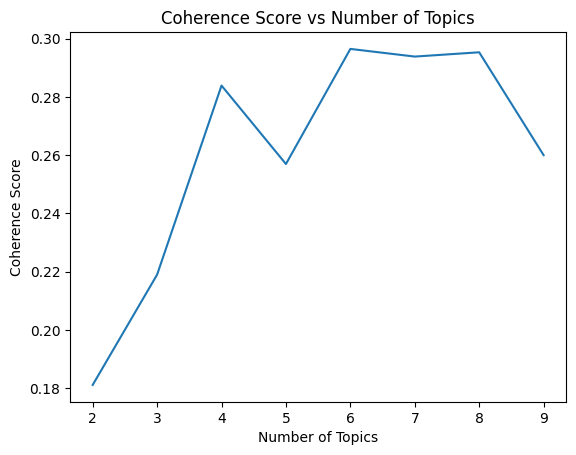

Optimal number of topics: 6


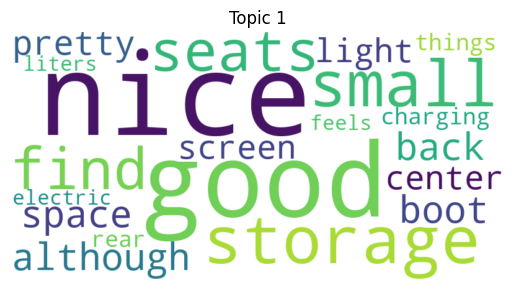

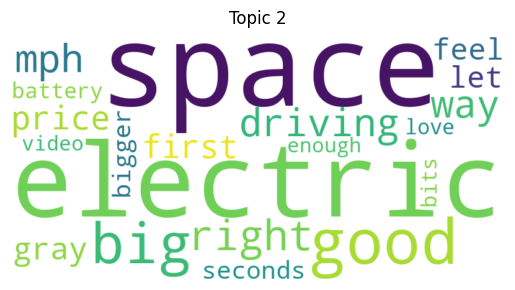

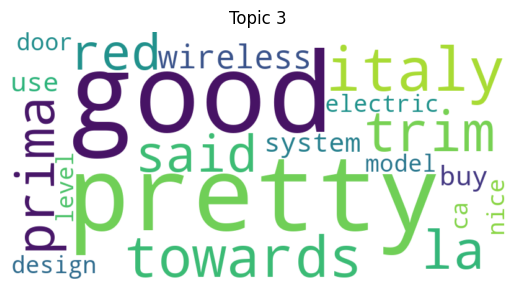

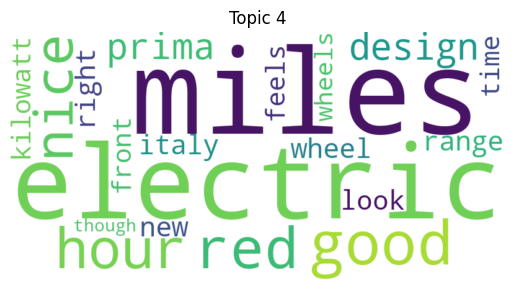

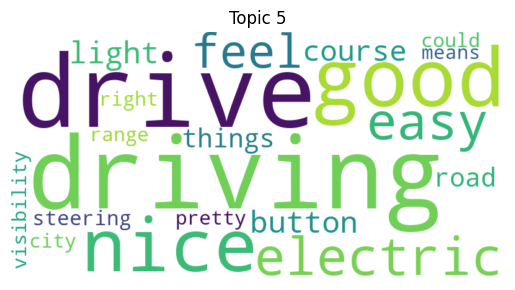

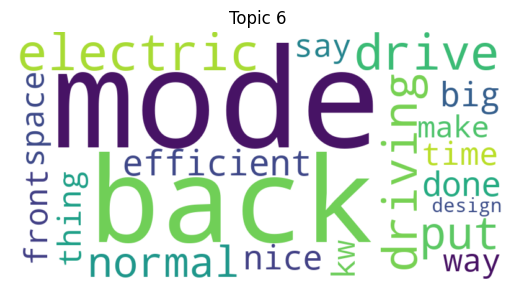

In [8]:
## YOUTUBE TRANSCRIPTS 600e
RANDOM_SEED = 1234567 #1234567 - 6 topics

# Drop 'Video ID', 'Title and 'Channel Name' columns
transcripts_600e = transcripts_600e.drop(columns=['Video ID', 'Title', 'Channel Name'])

# Preprocessing Function
def preprocess(text):
    t600e_custom_stopwords = set(stopwords.words('english'))
    t600e_custom_stopwords.update(['car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in t600e_custom_stopwords]
        return tokens
    else:
        return []

t600e_custom_stopwords = set(stopwords.words('english'))
t600e_custom_stopwords.update(['car', 'cars', 'uh', 'yes', 'go', 'e', 'oh',
                             'black', 'grey', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona', 'kind', 'want', 'mean', 'fat', 'um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be','much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
# Preprocess the documents
t600e_processed_docs = [preprocess(doc) for doc in transcripts_600e['Transcript Part']]
print("Processed Documents:", t600e_processed_docs[:5])  # Print only the first 5 for brevity

# Create a dictionary from the processed documents
t600e_dictionary = corpora.Dictionary(t600e_processed_docs)
print("Dictionary:", t600e_dictionary.token2id)

# Create a corpus from the dictionary
t600e_corpus = [t600e_dictionary.doc2bow(doc) for doc in t600e_processed_docs]
print("Corpus:", t600e_corpus[:5])  # Print only the first 5 for brevity

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=15,
            random_state=RANDOM_SEED  # Set the random seed here
        )
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
t600e_limit = 10
t600e_start = 2
t600e_step = 1
t600e_model_list, t600e_coherence_values = compute_coherence_values(t600e_dictionary, t600e_corpus, t600e_processed_docs, t600e_limit, t600e_start, t600e_step)

# Plotting the coherence scores
x = range(t600e_start, t600e_limit, t600e_step)
plt.plot(x, t600e_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Choosing the optimal number of topics
t600e_optimal_num_topics = x[t600e_coherence_values.index(max(t600e_coherence_values))]
print(f"Optimal number of topics: {t600e_optimal_num_topics}")

# Train the optimal LDA model
t600e_optimal_model = t600e_model_list[t600e_coherence_values.index(max(t600e_coherence_values))]

# Visualize topics using word clouds
for i in range(t600e_optimal_num_topics):
    plt.figure()
    t600e_word_frequencies = dict(t600e_optimal_model.show_topic(i, 20))
    t600e_filtered_word_frequencies = {word: freq for word, freq in t600e_word_frequencies.items() if word not in t600e_custom_stopwords}
    t600e_wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=50, 
        background_color='white', 
        stopwords=t600e_custom_stopwords,
        random_state=RANDOM_SEED  # Set the random seed here
    ).generate_from_frequencies(t600e_filtered_word_frequencies)
    plt.imshow(t600e_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i+1}")
    plt.show()

In [9]:
# Visualise topics using pyLDAvis
t600e_vis = gensimvis.prepare(t600e_optimal_model, t600e_corpus, t600e_dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(t600e_vis)

In [10]:
# Get the topic distribution for each document
t600e_topic_matrix = [t600e_optimal_model[doc] for doc in t600e_corpus]

# Extract topic probabilities and add them as columns
transcripts_600e['Topic 1'] = [dict(doc).get(0, 0) for doc in t600e_topic_matrix]
transcripts_600e['Topic 2'] = [dict(doc).get(1, 0) for doc in t600e_topic_matrix]
transcripts_600e['Topic 3'] = [dict(doc).get(2, 0) for doc in t600e_topic_matrix]
transcripts_600e['Topic 4'] = [dict(doc).get(3, 0) for doc in t600e_topic_matrix]
transcripts_600e['Topic 5'] = [dict(doc).get(4, 0) for doc in t600e_topic_matrix]
transcripts_600e['Topic 6'] = [dict(doc).get(5, 0) for doc in t600e_topic_matrix]

# Display the table with the new topic columns
transcripts_600e.head()

,Transcript Part,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,foreign 500e and you should it's brilliant but...,0.917218,0.000000,0.000000,0.078186,0.0,0.0
1,but maybe someone forgot to tell them that the...,0.000000,0.000000,0.993696,0.000000,0.0,0.0
2,yes the first thing he notices how quiet it is...,0.000000,0.992816,0.000000,0.000000,0.0,0.0
3,but in here they really do whichever mode you'...,0.993827,0.000000,0.000000,0.000000,0.0,0.0
4,it's a shame it's not a bit quicker although s...,0.968880,0.000000,0.000000,0.000000,0.0,0.0


In [11]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each transcript part
transcripts_600e['sentiment'] = transcripts_600e['Transcript Part'].apply(lambda x: analyzer.polarity_scores(x))

# Extract sentiment scores into separate columns
transcripts_600e['neg'] = transcripts_600e['sentiment'].apply(lambda x: x['neg'])
transcripts_600e['neu'] = transcripts_600e['sentiment'].apply(lambda x: x['neu'])
transcripts_600e['pos'] = transcripts_600e['sentiment'].apply(lambda x: x['pos'])
transcripts_600e['compound'] = transcripts_600e['sentiment'].apply(lambda x: x['compound'])

# Drop intermediate sentiment column
transcripts_600e = transcripts_600e.drop(columns=['sentiment'])

# Display the final DataFrame
print(transcripts_600e.head())


                                     Transcript Part   Topic 1   Topic 2  \
0  foreign 500e and you should it's brilliant but...  0.917218  0.000000   
1  but maybe someone forgot to tell them that the...  0.000000  0.000000   
2  yes the first thing he notices how quiet it is...  0.000000  0.992816   
3  but in here they really do whichever mode you'...  0.993827  0.000000   
4  it's a shame it's not a bit quicker although s...  0.968880  0.000000   

    Topic 3   Topic 4  Topic 5  Topic 6    neg    neu    pos  compound  
0  0.000000  0.078186      0.0      0.0  0.038  0.800  0.162    0.9949  
1  0.993696  0.000000      0.0      0.0  0.032  0.809  0.159    0.9925  
2  0.000000  0.000000      0.0      0.0  0.070  0.780  0.150    0.9793  
3  0.000000  0.000000      0.0      0.0  0.071  0.754  0.174    0.9908  
4  0.000000  0.000000      0.0      0.0  0.093  0.799  0.109    0.3454  


# 500e - YouTube Transcripts

In [12]:
transcripts_500e_original = pd.read_csv('500e - YouTube Transcripts_Split.csv')
transcripts_500e = transcripts_500e_original.copy()
transcripts_500e.head()

,Video ID,Title,Channel Name,Transcript Part
0,0kDbvxpjLZs,New Fiat 500 electric in-depth review: another...,Carbuyer,[Music] the fiat 500 is one of the most popula...
1,0kDbvxpjLZs,New Fiat 500 electric in-depth review: another...,Carbuyer,i mean i can only dream of having wireless app...
2,0kDbvxpjLZs,New Fiat 500 electric in-depth review: another...,Carbuyer,i mean it just feels so quiet but so nippy and...
3,0kDbvxpjLZs,New Fiat 500 electric in-depth review: another...,Carbuyer,and then you're not going to want to use it th...
4,0kDbvxpjLZs,New Fiat 500 electric in-depth review: another...,Carbuyer,it's perfect size actually the vwe up and the ...


Processed Documents: [['music', 'popular', 'small', 'sale', 'bought', 'popular', 'necessarily', 'best', 'bought', 'old', 'first', 'starting', 'feel', 'long', 'tooth', 'new', 'look', 'electric', 'looks', 'familiar', 'feels', 'anything', 'tell', 'review', 'subscribe', 'please', 'bell', 'button', 'share', 'share', 'friends', 'worth', 'mentioning', 'buy', 'old', 'hybrid', 'badge', 'boot', 'lid', 'less', 'pure', 'electric', 'miles', 'charge', 'look', 'closely', 'new', 'front', 'end', 'new', 'lights', 'look', 'cute', 'eyelids', 'new', 'bumpers', 'grill', 'either', 'overall', 'shape', 'pretty', 'iconic', 'though', 'stays', 'buy', 'retractable', 'roof', 'two', 'half', 'grand', 'extra', 'biggest', 'visual', 'changes', 'come', 'cabin', 'nice', 'ten', 'quarter', 'inch', 'screen', 'middle', 'optional', 'lower', 'trims', 'nice', 'digital', 'instrument', 'panel', 'behind', 'steering', 'wheel', 'looks', 'lovely', 'infotainment', 'goodness', 'better', 'contend', 'functional', 'loads', 'features', 'res

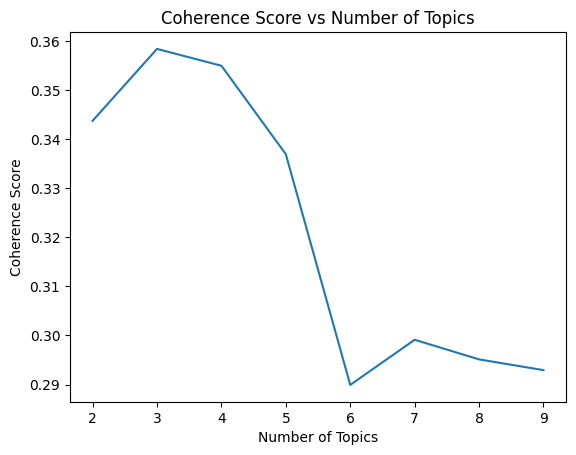

Optimal number of topics: 3


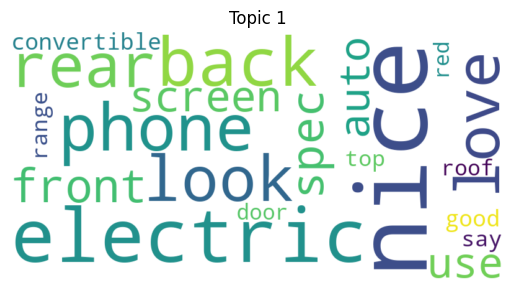

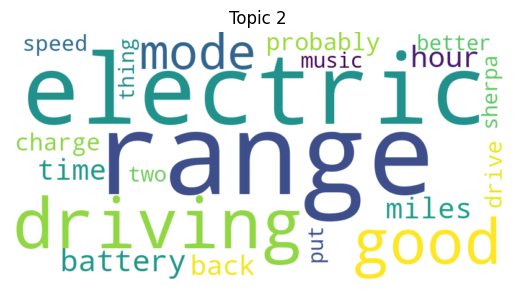

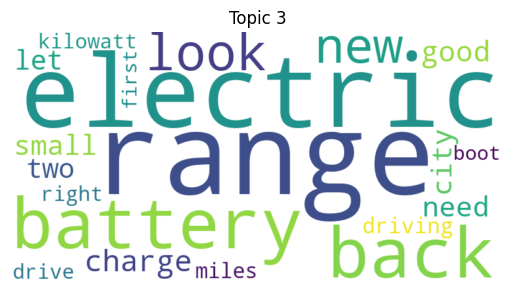

In [13]:
## YOUTUBE TRANSCRIPTS 500e
RANDOM_SEED = 77 # 123 2t, 55 4t 77 3t

# Drop 'Video ID', 'Title and 'Channel Name' columns
transcripts_500e = transcripts_500e.drop(columns=['Video ID', 'Title', 'Channel Name'])

# Preprocessing Function
def preprocess(text):
    t500e_custom_stopwords = set(stopwords.words('english'))
    t500e_custom_stopwords.update(['car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in t500e_custom_stopwords]
        return tokens
    else:
        return []

t500e_custom_stopwords = set(stopwords.words('english'))
t500e_custom_stopwords.update(['car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
# Preprocess the documents
t500e_processed_docs = [preprocess(doc) for doc in transcripts_500e['Transcript Part']]
print("Processed Documents:", t500e_processed_docs[:5])  # Print only the first 5 for brevity

# Create a dictionary from the processed documents
t500e_dictionary = corpora.Dictionary(t500e_processed_docs)
print("Dictionary:", t500e_dictionary.token2id)

# Create a corpus from the dictionary
t500e_corpus = [t500e_dictionary.doc2bow(doc) for doc in t500e_processed_docs]
print("Corpus:", t500e_corpus[:5])  # Print only the first 5 for brevity

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=15,
            random_state=RANDOM_SEED  # Set the random seed here
        )
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
t500e_limit = 10
t500e_start = 2
t500e_step = 1
t500e_model_list, t500e_coherence_values = compute_coherence_values(t500e_dictionary, t500e_corpus, t500e_processed_docs, t500e_limit, t500e_start, t500e_step)

# Plotting the coherence scores
x = range(t500e_start, t500e_limit, t500e_step)
plt.plot(x, t500e_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Choosing the optimal number of topics
t500e_optimal_num_topics = x[t500e_coherence_values.index(max(t500e_coherence_values))]
print(f"Optimal number of topics: {t500e_optimal_num_topics}")

# Train the optimal LDA model
t500e_optimal_model = t500e_model_list[t500e_coherence_values.index(max(t500e_coherence_values))]

# Visualise topics using word clouds
for i in range(t500e_optimal_num_topics):
    plt.figure()
    t500e_word_frequencies = dict(t500e_optimal_model.show_topic(i, 20))
    t500e_filtered_word_frequencies = {word: freq for word, freq in t500e_word_frequencies.items() if word not in t500e_custom_stopwords}
    t500e_wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=50, 
        background_color='white', 
        stopwords=t500e_custom_stopwords,
        random_state=RANDOM_SEED  # Set the random seed here
    ).generate_from_frequencies(t500e_filtered_word_frequencies)
    plt.imshow(t500e_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i+1}")
    plt.show()

In [14]:
# Visualise topics using pyLDAvis
t500e_vis = gensimvis.prepare(t500e_optimal_model, t500e_corpus, t500e_dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(t500e_vis)

In [15]:
# Get the topic distribution for each document
t500e_topic_matrix = [t500e_optimal_model[doc] for doc in t500e_corpus]

# Extract topic probabilities and add them as columns
transcripts_500e['Topic 1'] = [dict(doc).get(0, 0) for doc in t500e_topic_matrix]
transcripts_500e['Topic 2'] = [dict(doc).get(1, 0) for doc in t500e_topic_matrix]
transcripts_500e['Topic 3'] = [dict(doc).get(2, 0) for doc in t500e_topic_matrix]

# Display the table with the new topic columns
transcripts_500e.head()

,Transcript Part,Topic 1,Topic 2,Topic 3
0,[Music] the fiat 500 is one of the most popula...,0.0,0.000000,0.992714
1,i mean i can only dream of having wireless app...,0.0,0.000000,0.995278
2,i mean it just feels so quiet but so nippy and...,0.0,0.483902,0.513168
3,and then you're not going to want to use it th...,0.0,0.000000,0.993710
4,it's perfect size actually the vwe up and the ...,0.0,0.000000,0.994729


In [16]:
# Initialise VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyse sentiment for each transcript part
transcripts_500e['sentiment'] = transcripts_500e['Transcript Part'].apply(lambda x: analyzer.polarity_scores(x))

# Extract sentiment scores into separate columns
transcripts_500e['neg'] = transcripts_500e['sentiment'].apply(lambda x: x['neg'])
transcripts_500e['neu'] = transcripts_500e['sentiment'].apply(lambda x: x['neu'])
transcripts_500e['pos'] = transcripts_500e['sentiment'].apply(lambda x: x['pos'])
transcripts_500e['compound'] = transcripts_500e['sentiment'].apply(lambda x: x['compound'])

# Drop intermediate sentiment column
transcripts_500e = transcripts_500e.drop(columns=['sentiment'])

# Display the final DataFrame
print(transcripts_500e.head())

                                     Transcript Part  Topic 1   Topic 2  \
0  [Music] the fiat 500 is one of the most popula...      0.0  0.000000   
1  i mean i can only dream of having wireless app...      0.0  0.000000   
2  i mean it just feels so quiet but so nippy and...      0.0  0.483902   
3  and then you're not going to want to use it th...      0.0  0.000000   
4  it's perfect size actually the vwe up and the ...      0.0  0.000000   

    Topic 3    neg    neu    pos  compound  
0  0.992714  0.025  0.744  0.231    0.9972  
1  0.995278  0.020  0.823  0.157    0.9962  
2  0.513168  0.030  0.807  0.163    0.9943  
3  0.993710  0.077  0.768  0.155    0.9833  
4  0.994729  0.030  0.834  0.136    0.9907  


# 600e - YouTube Comments

In [17]:
comments_600e_original = pd.read_csv('600e - YouTube Comments_Filtered.csv')
comments_600e = comments_600e_original.copy()
comments_600e.head()

,Date,VideoID,Comment
0,2024-03-08,AXGNb76QgH0,25000 is a fair price
1,2024-03-04,AXGNb76QgH0,it looks solid and i know its a great driving ...
2,2024-02-24,AXGNb76QgH0,really love the video and review of new fiat 6...
3,2024-02-16,AXGNb76QgH0,imagine if fiat invested in perfecting the 500...
4,2024-02-13,AXGNb76QgH0,my wife has a 500 c and all we love it nobody ...


Processed Documents: [['fair', 'price'], ['looks', 'solid', 'great', 'driving', 'machine'], ['love', 'video', 'review', 'new', 'weekend', 'ive', 'spend', 'beautifull', 'fun', 'drive', 'say', 'love'], ['imagine', 'invested', 'perfecting', 'platform', 'increase', 'performance', 'reliability', 'build', 'quality', 'vs', 'redesigning', 'releasing', 'brand', 'new', 'model', 'relying', 'things', 'design', 'contemporary', 'tastes', 'may', 'change', 'hard', 'argue', 'performance', 'reliability', 'towards', 'top', 'buyers', 'wish', 'list'], ['wife', 'c', 'love', 'nobody', 'knows', 'best', 'instead', 'bigger', 'use', 'longer', 'summer', 'trips', 'perfect', 'rletive', 'small', 'fifi', 'thinking', 'abut']]
Dictionary: {'fair': 0, 'price': 1, 'driving': 2, 'great': 3, 'looks': 4, 'machine': 5, 'solid': 6, 'beautifull': 7, 'drive': 8, 'fun': 9, 'ive': 10, 'love': 11, 'new': 12, 'review': 13, 'say': 14, 'spend': 15, 'video': 16, 'weekend': 17, 'argue': 18, 'brand': 19, 'build': 20, 'buyers': 21, 'chan

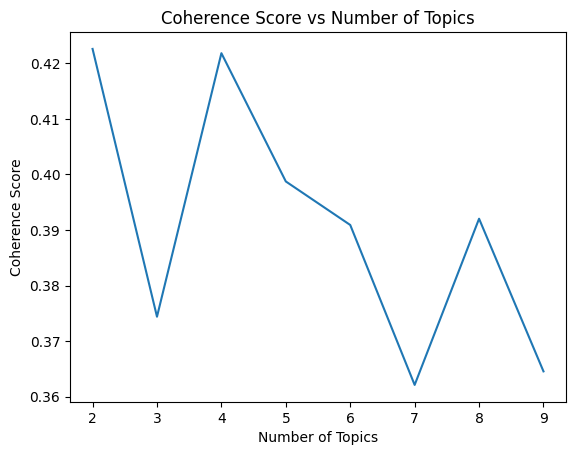

Optimal number of topics: 2


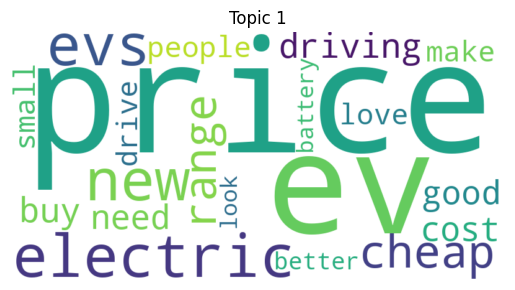

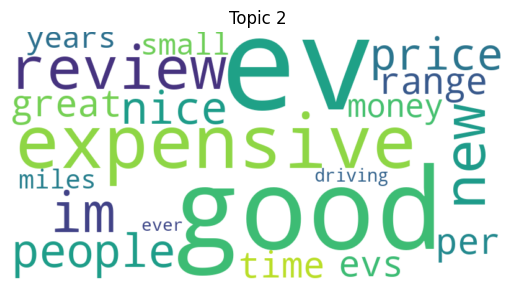

In [18]:
RANDOM_SEED = 386432  # 81 cheap/expensive 2t, 123 - better, 556

# Drop 'VideoID' and 'Date' columns
comments_600e = comments_600e.drop(columns=['VideoID', 'Date'])

# Preprocessing Function
def preprocess(text):
    c600e_custom_stopwords = set(stopwords.words('english'))
    c600e_custom_stopwords.update(['car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in c600e_custom_stopwords]
        return tokens
    else:
        return []

c600e_custom_stopwords = set(stopwords.words('english'))
c600e_custom_stopwords.update(['car', 'cars', 'uh', 'yes', 'go', 'e', 'oh',
                             'black', 'grey', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona', 'kind', 'want', 'mean', 'fat', 'um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be','much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
# Preprocess the documents
c600e_processed_docs = [preprocess(doc) for doc in comments_600e['Comment']]
print("Processed Documents:", c600e_processed_docs[:5])  # Print only the first 5 for brevity

# Create a dictionary from the processed documents
c600e_dictionary = corpora.Dictionary(c600e_processed_docs)
print("Dictionary:", c600e_dictionary.token2id)

# Create a corpus from the dictionary
c600e_corpus = [c600e_dictionary.doc2bow(doc) for doc in c600e_processed_docs]
print("Corpus:", c600e_corpus[:5])  # Print only the first 5 for brevity

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=15,
            random_state=RANDOM_SEED  # Set the random seed here
        )
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
c600e_limit = 10
c600e_start = 2
c600e_step = 1
c600e_model_list, c600e_coherence_values = compute_coherence_values(c600e_dictionary, c600e_corpus, c600e_processed_docs, c600e_limit, c600e_start, c600e_step)

# Plotting the coherence scores
x = range(c600e_start, c600e_limit, c600e_step)
plt.plot(x, c600e_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Choosing the optimal number of topics
c600e_optimal_num_topics = x[c600e_coherence_values.index(max(c600e_coherence_values))]
print(f"Optimal number of topics: {c600e_optimal_num_topics}")

# Train the optimal LDA model
c600e_optimal_model = c600e_model_list[c600e_coherence_values.index(max(c600e_coherence_values))]

# Visualize topics using word clouds
for i in range(c600e_optimal_num_topics):
    plt.figure()
    c600e_word_frequencies = dict(c600e_optimal_model.show_topic(i, 20))
    c600e_filtered_word_frequencies = {word: freq for word, freq in c600e_word_frequencies.items() if word not in c600e_custom_stopwords}
    c600e_wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=50, 
        background_color='white', 
        stopwords=c600e_custom_stopwords,
        random_state=RANDOM_SEED  # Set the random seed here
    ).generate_from_frequencies(c600e_filtered_word_frequencies)
    plt.imshow(c600e_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i+1}")
    plt.show()

In [19]:
# Visualise topics using pyLDAvis
c600e_vis = gensimvis.prepare(c600e_optimal_model, c600e_corpus, c600e_dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(c600e_vis)

In [20]:
# Get the topic distribution for each document
c600e_topic_matrix = [c600e_optimal_model[doc] for doc in c600e_corpus]

# Extract topic probabilities and add them as columns
comments_600e['Topic 1'] = [dict(doc).get(0, 0) for doc in c600e_topic_matrix]
comments_600e['Topic 2'] = [dict(doc).get(1, 0) for doc in c600e_topic_matrix]

# Add 'Date' column from the original table
comments_600e['Date'] = comments_600e_original['Date']

# Display the table with the new topic columns
comments_600e.head()

,Comment,Topic 1,Topic 2,Date
0,25000 is a fair price,0.335070,0.664930,2024-03-08
1,it looks solid and i know its a great driving ...,0.540355,0.459645,2024-03-04
2,really love the video and review of new fiat 6...,0.845087,0.154913,2024-02-24
3,imagine if fiat invested in perfecting the 500...,0.021837,0.978163,2024-02-16
4,my wife has a 500 c and all we love it nobody ...,0.960988,0.039012,2024-02-13


In [21]:
# Initialise VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyse sentiment for each comment
comments_600e['sentiment'] = comments_600e['Comment'].apply(lambda x: analyzer.polarity_scores(x))

# Extract sentiment scores into separate columns
comments_600e['neg'] = comments_600e['sentiment'].apply(lambda x: x['neg'])
comments_600e['neu'] = comments_600e['sentiment'].apply(lambda x: x['neu'])
comments_600e['pos'] = comments_600e['sentiment'].apply(lambda x: x['pos'])
comments_600e['compound'] = comments_600e['sentiment'].apply(lambda x: x['compound'])

# Drop intermediate sentiment column
comments_600e = comments_600e.drop(columns=['sentiment'])

# Display the final DataFrame
print(comments_600e.head())


                                             Comment   Topic 1   Topic 2  \
0                              25000 is a fair price  0.335070  0.664930   
1  it looks solid and i know its a great driving ...  0.540355  0.459645   
2  really love the video and review of new fiat 6...  0.845087  0.154913   
3  imagine if fiat invested in perfecting the 500...  0.021837  0.978163   
4  my wife has a 500 c and all we love it nobody ...  0.960988  0.039012   

         Date    neg    neu    pos  compound  
0  2024-03-08  0.000  0.566  0.434    0.3182  
1  2024-03-04  0.000  0.551  0.449    0.6908  
2  2024-02-24  0.000  0.687  0.313    0.9229  
3  2024-02-16  0.057  0.753  0.190    0.8316  
4  2024-02-13  0.040  0.821  0.140    0.7555  


# 500e - YouTube Comments

In [22]:
comments_500e_original = pd.read_csv('500e - YouTube Comments_Filtered.csv')
comments_500e = comments_500e_original.copy()
comments_500e.head()

,Date,VideoID,Comment
0,2024-05-04,0kDbvxpjLZs,9 seconds for an electric car thats especially...
1,2024-02-16,0kDbvxpjLZs,good honest review thanks like the car im i...
2,2024-01-06,0kDbvxpjLZs,this is a genius car this is a car that you do...
3,2023-10-21,0kDbvxpjLZs,got a twinair mito done 60k in it its great ...
4,2023-09-16,0kDbvxpjLZs,no spare wheel is a dealbreaker i love that ga...


Processed Documents: [['seconds', 'electric', 'thats', 'especially', 'pathetic'], ['good', 'honest', 'review', 'thanks', 'im', 'australia', 'cant', 'wait', 'test', 'drive'], ['genius', 'buy', 'lease', 'company'], ['twinair', 'mito', 'done', 'great', 'thing', 'puts', 'italians', 'aint', 'best', 'automotive', 'electrics', 'id', 'tentative', 'trusting', 'build', 'electric', 'thats', 'reliable', 'long', 'term', 'especially', 'stab', 'already', 'already', 'issued', 'recalls', 'bunch', 'evs', 'cool', 'feel', 'guinea', 'pig', 'saying'], ['spare', 'wheel', 'dealbreaker', 'love', 'gap', 'low', 'centre', 'console', 'dashboard', 'thoughit', 'looks', 'super', 'easy', 'scoot', 'side', 'extremely', 'practical']]
Dictionary: {'electric': 0, 'especially': 1, 'pathetic': 2, 'seconds': 3, 'thats': 4, 'australia': 5, 'cant': 6, 'drive': 7, 'good': 8, 'honest': 9, 'im': 10, 'review': 11, 'test': 12, 'thanks': 13, 'wait': 14, 'buy': 15, 'company': 16, 'genius': 17, 'lease': 18, 'aint': 19, 'already': 20, '

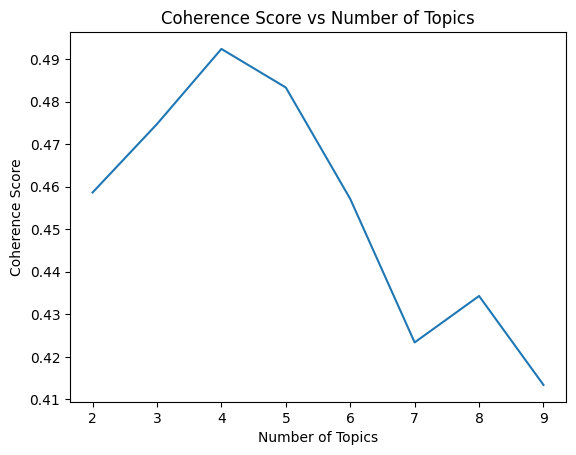

Optimal number of topics: 4


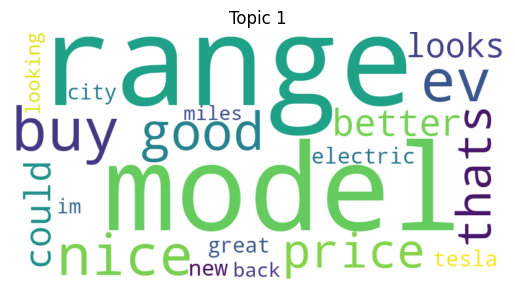

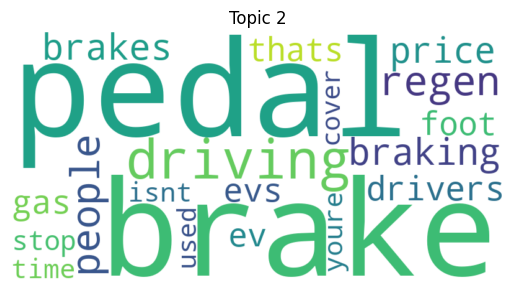

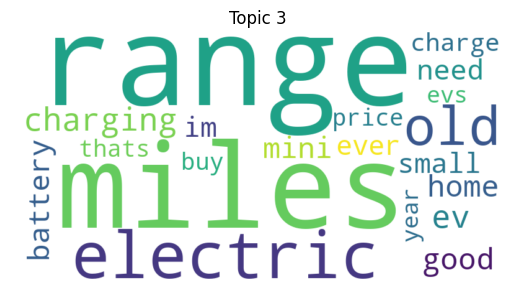

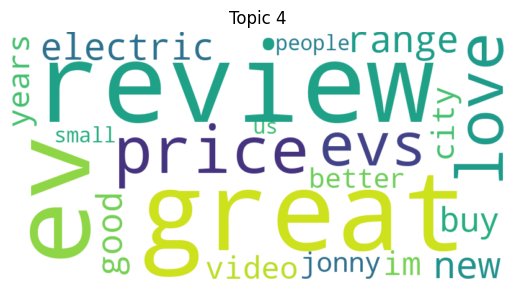

In [23]:
RANDOM_SEED = 386432  # 81 cheap/expensive 2t, 123 - better, 556

# Drop VideoID and Date columns
comments_500e = comments_500e.drop(columns=['VideoID', 'Date'])

# Preprocessing Function
def preprocess(text):
    c500e_custom_stopwords = set(stopwords.words('english'))
    c500e_custom_stopwords.update(['car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in c500e_custom_stopwords]
        return tokens
    else:
        return []

c500e_custom_stopwords = set(stopwords.words('english'))
c500e_custom_stopwords.update(['car', 'cars', 'uh', 'yes', 'go', 'e', 'oh',
                             'black', 'grey', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona', 'kind', 'want', 'mean', 'fat', 'um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be','much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'])  # Add your words here
    
# Preprocess the documents
c500e_processed_docs = [preprocess(doc) for doc in comments_500e['Comment']]
print("Processed Documents:", c500e_processed_docs[:5])  # Print only the first 5 for brevity

# Create a dictionary from the processed documents
c500e_dictionary = corpora.Dictionary(c500e_processed_docs)
print("Dictionary:", c500e_dictionary.token2id)

# Create a corpus from the dictionary
c500e_corpus = [c500e_dictionary.doc2bow(doc) for doc in c500e_processed_docs]
print("Corpus:", c500e_corpus[:5])  # Print only the first 5 for brevity

# Function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus, 
            num_topics=num_topics, 
            id2word=dictionary, 
            passes=15,
            random_state=RANDOM_SEED  # Set the random seed here
        )
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
c500e_limit = 10
c500e_start = 2
c500e_step = 1
c500e_model_list, c500e_coherence_values = compute_coherence_values(c500e_dictionary, c500e_corpus, c500e_processed_docs, c500e_limit, c500e_start, c500e_step)

# Plotting the coherence scores
x = range(c500e_start, c500e_limit, c500e_step)
plt.plot(x, c500e_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Choosing the optimal number of topics
c500e_optimal_num_topics = x[c500e_coherence_values.index(max(c500e_coherence_values))]
print(f"Optimal number of topics: {c500e_optimal_num_topics}")

# Train the optimal LDA model
c500e_optimal_model = c500e_model_list[c500e_coherence_values.index(max(c500e_coherence_values))]

# Visualize topics using word clouds
for i in range(c500e_optimal_num_topics):
    plt.figure()
    c500e_word_frequencies = dict(c500e_optimal_model.show_topic(i, 20))
    c500e_filtered_word_frequencies = {word: freq for word, freq in c500e_word_frequencies.items() if word not in c500e_custom_stopwords}
    c500e_wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=50, 
        background_color='white', 
        stopwords=c500e_custom_stopwords,
        random_state=RANDOM_SEED  # Set the random seed here
    ).generate_from_frequencies(c500e_filtered_word_frequencies)
    plt.imshow(c500e_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i+1}")
    plt.show()

In [24]:
# Visualise topics using pyLDAvis
c500e_vis = gensimvis.prepare(c500e_optimal_model, c500e_corpus, c500e_dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(c500e_vis)

In [25]:
# Get the topic distribution for each document
c500e_topic_matrix = [c500e_optimal_model[doc] for doc in c500e_corpus]

# Extract topic probabilities and add them as columns
comments_500e['Topic 1'] = [dict(doc).get(0, 0) for doc in c500e_topic_matrix]
comments_500e['Topic 2'] = [dict(doc).get(1, 0) for doc in c500e_topic_matrix]

# Add 'Date' columns from the original table
comments_500e['Date'] = comments_500e_original['Date']

# Display the table with the new topic columns
comments_500e.head()

,Comment,Topic 1,Topic 2,Date
0,9 seconds for an electric car thats especially...,0.045099,0.518910,2024-05-04
1,good honest review thanks like the car im i...,0.023679,0.023933,2024-02-16
2,this is a genius car this is a car that you do...,0.051475,0.408838,2024-01-06
3,got a twinair mito done 60k in it its great ...,0.000000,0.706900,2023-10-21
4,no spare wheel is a dealbreaker i love that ga...,0.957093,0.014267,2023-09-16


In [26]:
# Assuming the necessary imports and initialization have been done
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each comment
comments_500e['sentiment'] = comments_500e['Comment'].apply(lambda x: analyzer.polarity_scores(x))

# Extract sentiment scores into separate columns
comments_500e['neg'] = comments_500e['sentiment'].apply(lambda x: x['neg'])
comments_500e['neu'] = comments_500e['sentiment'].apply(lambda x: x['neu'])
comments_500e['pos'] = comments_500e['sentiment'].apply(lambda x: x['pos'])
comments_500e['compound'] = comments_500e['sentiment'].apply(lambda x: x['compound'])

# Drop intermediate sentiment column
comments_500e = comments_500e.drop(columns=['sentiment'])

# Display the final DataFrame
print(comments_500e.head())


                                             Comment   Topic 1   Topic 2  \
0  9 seconds for an electric car thats especially...  0.045099  0.518910   
1  good honest review thanks   like the car  im i...  0.023679  0.023933   
2  this is a genius car this is a car that you do...  0.051475  0.408838   
3  got a twinair mito  done 60k in it  its great ...  0.000000  0.706900   
4  no spare wheel is a dealbreaker i love that ga...  0.957093  0.014267   

         Date    neg    neu    pos  compound  
0  2024-05-04  0.363  0.637  0.000   -0.6115  
1  2024-02-16  0.000  0.508  0.492    0.8910  
2  2024-01-06  0.000  1.000  0.000    0.0000  
3  2023-10-21  0.102  0.794  0.103    0.0259  
4  2023-09-16  0.085  0.650  0.266    0.8807  
